In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
%load_ext autoreload

In [2]:
logging.debug("test")

2023-12-19 13:25:47,051 - root - DEBUG - test


In [3]:
import pandas as pd
import os
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2023-12-19 13:25:47,669 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-19 13:25:47,670 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-12-19 13:25:48,432 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2023-12-19 13:25:48,441 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2023-12-19 13:25:48,444 - matplotlib - DEBUG - interactive is False
2023-12-19 13:25:48,445 - matplotlib - DEBUG - platform is linux
2023-12-19 13:25:48,530 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2023-12-19 13:25:48,539 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json


# Load Data

In [4]:
# path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
maxquant_file_dict = (
    "/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/"
    "combined/txt/evidence_1_FilteredByClosestRT_transfer_RT_pred_filtered_withIso.pkl"
)
maxquant_file_exp = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/MQ/combined/txt/evidence_1.txt"
)

MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
# experiment specific
result_dir = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_MZtol0.0_condpeakRange_alpha0.0_threshold_abthres0.001_missabthres0.5_convergence_NoIntercept_mix"
)

basename = os.path.basename(result_dir)
output_file = os.path.join(result_dir, basename + "_output")  # filename

In [5]:
from result_analysis.result_analysis import SBSResult

Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_dict)
Maxquant_result_exp = pd.read_csv(maxquant_file_exp, sep="\t")
sum_peak = pd.read_csv(
    os.path.join(result_dir, "sum_peak_width3_None_Retention_time_new.csv")
)
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_path)
MS1Scans_NoArray["scan_number"] = MS1Scans_NoArray.index.astype(int)

peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width3_None_Retention_time_new.csv")
)
peak_results.matched.describe()

count     160178
unique         2
top        False
freq      108483
Name: matched, dtype: object

In [6]:
SBS_result = SBSResult(
    ref_df=Maxquant_result_dict,
    exp_df=Maxquant_result_exp,
    RT_tol=1.0,
    sum_peak=sum_peak,
)
ref_exp_df_inner = SBS_result.ref_exp_df_inner
selected_id = ref_exp_df_inner["id"].unique()

2023-12-19 13:25:51,718 - result_analysis.result_analysis - DEBUG - Maxquant experiment file has 19186 entries.
2023-12-19 13:25:51,719 - result_analysis.result_analysis - DEBUG - columns after merge MQ dict and MQ exp Index(['Modified sequence', 'Charge', 'predicted_RT', 'id',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity', '_merge'],
      dtype='object')
2023-12-19 13:25:51,723 - result_analysis.result_analysis - DEBUG - Keeping 17758 entries with RT difference within 1.0
2023-12-19 13:25:51,723 - result_analysis.result_analysis - DEBUG - columns after filter by RT Index(['Modified sequence', 'Charge', 'predicted_RT', 'id',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity', '_merge',
       'RT_diff'],
      dtype='object')
2023-12-19 13:25:51,740 - result_analysis.result_analysis - DEBUG - Aggr

In [7]:
RT_ref = "predicted_RT"
RT_tol = 1
ref_exp_df_inner["sbs_window_left"] = ref_exp_df_inner[RT_ref] - RT_tol
ref_exp_df_inner["sbs_window_right"] = ref_exp_df_inner[RT_ref] + RT_tol

In [8]:
%autoreload 2
from postprocessing.peak_selection import match_time_to_scan


ref_exp_df_inner = match_time_to_scan(
    df=ref_exp_df_inner,
    MS1Scans_NoArray=MS1Scans_NoArray,
    time_cols=[
        "sbs_window_left",
        "sbs_window_right",
        "Calibrated retention time start",
        "Calibrated retention time finish",
    ],
)

2023-12-19 13:25:52.217064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 13:25:54,413 - tensorflow - DEBUG - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2023-12-19 13:25:54.868626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-19 13:25:55,233 - h5py._conv - DEBUG - Creating converter from 7 to 5
2023-12-19 13:25:55,234 - h5py._conv - DEBUG - Creating converter from 5 to 7
2023-12-19 13:25:55,234 - h5py._conv - DEBUG - Creating converter from 7 to 5
2023-12-19 13:25:55,235 - h5py._conv - DEBUG - Creating converter from 5 to 7
2023-12-19 13:26:08.932696: E tensorflow/compiler/xla/stream_executor/cuda/cud

# Exploring find_peaks algo

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks

x = electrocardiogram()[2000:4000]

2023-12-19 13:26:09,235 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-12-19 13:26:09,236 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-12-19 13:26:09,240 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-12-19 13:26:09,241 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2023-12-19 13:26:09,242 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='norm

2023-12-19 13:26:09,296 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifDogra-Regular.ttf', name='Noto Serif Dogra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-12-19 13:26:09,297 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/adf/AccanthisADFStd-Italic.otf', name='Accanthis ADF Std', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-12-19 13:26:09,298 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/tex-gyre/texgyreheros-bold.otf', name='TeX Gyre Heros', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2023-12-19 13:26:09,299 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', name='Liberation San

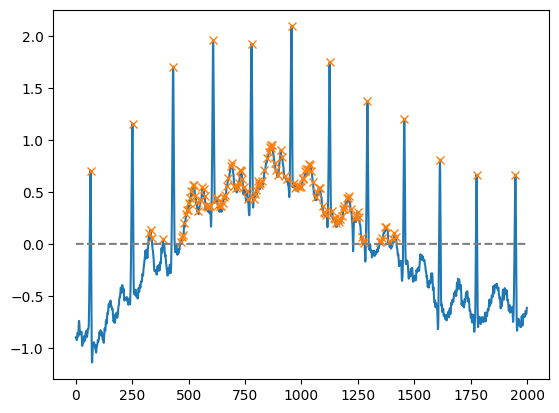

In [10]:
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

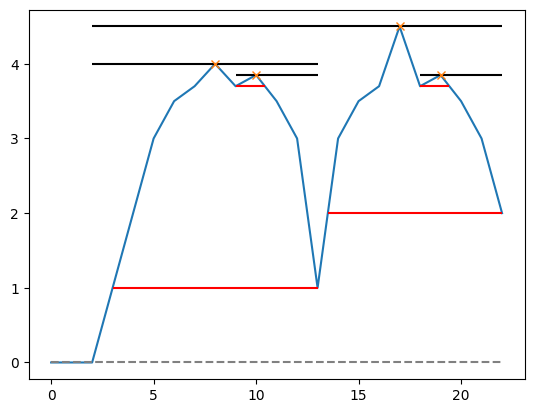

In [11]:
# Limit distance
x = np.array(
    [
        0,
        0,
        0,
        1,
        2,
        3,
        3.5,
        3.7,
        4,
        3.7,
        3.85,
        3.5,
        3,
        1,
        3,
        3.5,
        3.7,
        4.5,
        3.7,
        3.85,
        3.5,
        3,
        2,
    ]
)
peaks, properties = find_peaks(x, prominence=0, width=0, height=0, rel_height=1)
plt.plot(x)
for idx, peak in enumerate(peaks):
    # print(idx, peak)
    plt.hlines(
        xmin=properties["left_ips"][idx],
        xmax=properties["right_ips"][idx],
        y=properties["width_heights"][idx],
        color="red",
    )
    plt.hlines(
        xmin=properties["left_bases"][idx],
        xmax=properties["right_bases"][idx],
        y=properties["peak_heights"][idx],
        color="black",
    )
    # plt.hlines(
    #     xmin=peak - 0.5 * properties["widths"][idx],
    #     xmax=peak + 0.5 * properties["widths"][idx],
    #     y=properties["peak_heights"][idx],
    #     color="green",
    # )
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [12]:
properties

{'peak_heights': array([4.  , 3.85, 4.5 , 3.85]),
 'prominences': array([3.  , 0.15, 2.5 , 0.15]),
 'left_bases': array([ 2,  9,  2, 18]),
 'right_bases': array([13, 13, 22, 22]),
 'widths': array([10.        ,  1.42857143,  8.5       ,  1.42857143]),
 'width_heights': array([1. , 3.7, 2. , 3.7]),
 'left_ips': array([ 3. ,  9. , 13.5, 18. ]),
 'right_ips': array([13.        , 10.42857143, 22.        , 19.42857143])}

# Extract Activation Peak
see extract_peak.py

# Peak extraction with different width

Number of precursors: 55753
Label distribution:
False    208013
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  2.637660e+05        2.637660e+05  2.637660e+05  263766.000000  263766.000000  263766.000000
mean   100514.209747    1129.355470      14.737834    1127.000057      14.699651    1132.004455      14.780400       5.004398  3.133223e+07        2.018463e+06  4.677740e-01       0.566401       0.558739       1.125140
std     58028.936860     530.692603       8.916898     530.754764       8.914841     530.598154       8.919384       5.981154  1.427096e+08        1.025395e+07  3.053284e-01       0.711914       0.715395       1.406701
min         0.000000      

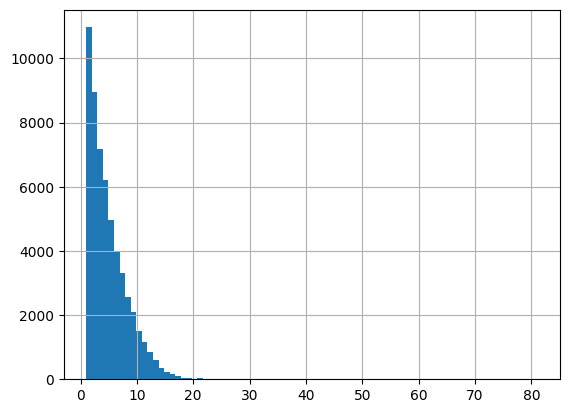

In [45]:
# Width = 1
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width1_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 55753
Label distribution:
False    202908
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  2.586610e+05        2.586610e+05  2.586610e+05  258661.000000  258661.000000  258661.000000
mean   100500.713942    1133.850623      14.807237    1131.461778      14.768472    1136.540514      14.850498       5.078736  3.180421e+07        2.053892e+06  4.675197e-01       0.566178       0.559251       1.125429
std     58042.986541     528.198222       8.886482     528.276702       8.884657     528.084525       8.888722       6.015908  1.440531e+08        1.035122e+07  3.055485e-01       0.712962       0.716464       1.409157
min         0.000000      

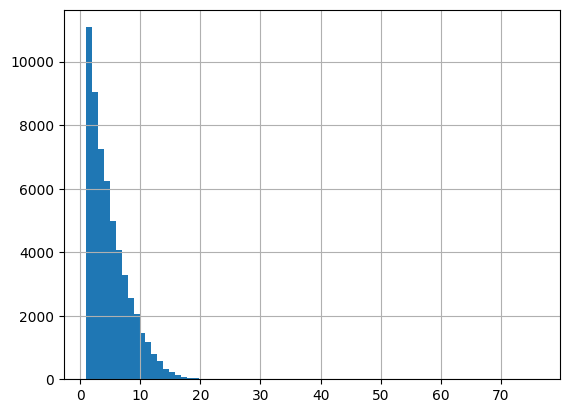

In [46]:
# Width = 2
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width2_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 51695
Label distribution:
False    108483
True      51695
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  1.601780e+05        1.601780e+05  1.601780e+05  160178.000000  160178.000000  160178.000000
mean   100302.708506    1142.212345      14.944811    1138.975365      14.892283    1145.935878      15.004608       6.960513  4.785421e+07        3.240916e+06  4.487215e-01       0.540794       0.536162       1.076956
std     58034.473869     527.948288       8.896179     528.104628       8.894360     527.722967       8.898489       7.009378  1.797651e+08        1.300499e+07  3.143144e-01       0.714881       0.718058       1.415272
min         0.000000      

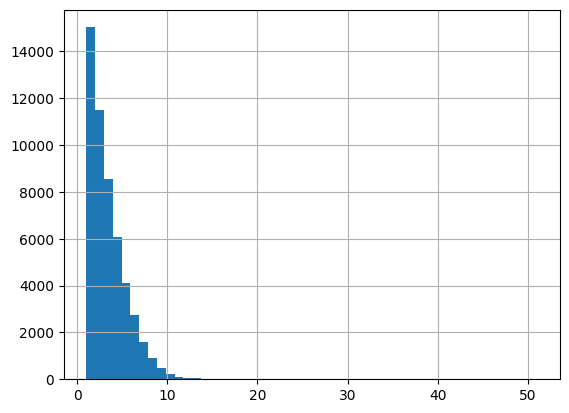

In [66]:
# Width = 3
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width3_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

3.971890897899969

array([[<Axes: title={'center': 'RT_diff_sum'}>]], dtype=object)

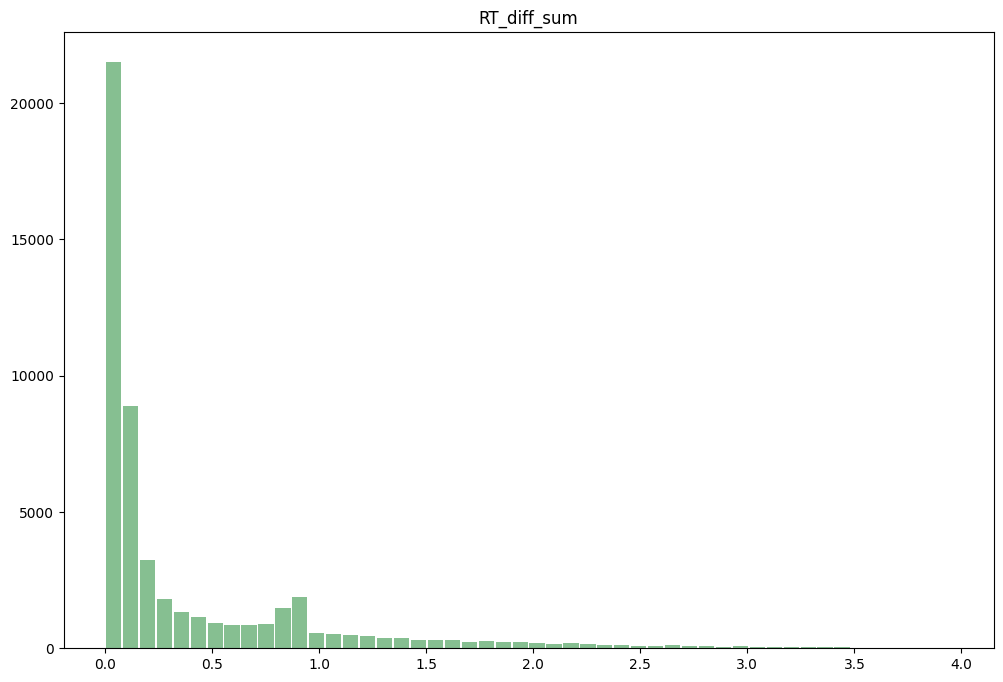

In [61]:
peak_results["RT_diff_sum"].quantile(0.99)
peak_results.loc[
    (peak_results.matched == 1) & (peak_results["RT_diff_sum"] <= 3.97)
].hist(
    column="RT_diff_sum",
    bins=50,
    grid=False,
    figsize=(12, 8),
    color="#86bf91",
    zorder=2,
    rwidth=0.9,
)

Number of precursors: 49362
Label distribution:
False    78326
True     49362
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  1.276880e+05        1.276880e+05  1.276880e+05  127688.000000  127688.000000  127688.000000
mean   100288.001418    1149.007025      15.051743    1145.332960      14.992082    1153.290442      15.120507       7.957482  5.778511e+07        3.993390e+06  4.340126e-01       0.523953       0.519493       1.043446
std     58051.711698     519.486899       8.766350     519.710087       8.764903     519.165352       8.768269       7.531420  1.994352e+08        1.446028e+07  3.169667e-01       0.709495       0.712316       1.405587
min         0.000000      37

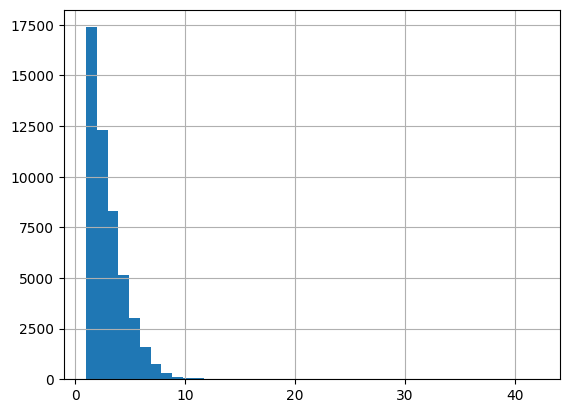

In [48]:
# Width = 4
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width4_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

# Train peak selection CNN model
peak_results mark the annotated data:
- matched: binary classification task


In [77]:
refit_activation_minima = np.load(output_file + "_activationMinima.npy")
refit_activation_minima_df = pd.DataFrame(refit_activation_minima).set_index(
    Maxquant_result_dict.index
)
refit_activation_minima_df.columns = refit_activation_minima_df.columns
# Only use precursors in selected id
refit_activation_minima_df_selected_id = refit_activation_minima_df.loc[selected_id]

## Peak Segmentation

In [16]:
%autoreload 2
from postprocessing.peak_selection import  prepare_seq_input_label
label, seq = prepare_seq_input_label(activation_df=refit_activation_minima_df_selected_id, 
                                    ref_dict_exp_inner_df =ref_exp_df_inner,
                                    log_intensity = True,
                                    standardize = "minmax")


In [17]:
%autoreload 2
from postprocessing.peak_selection import PeakSegModel

model = PeakSegModel(
    seq_input = seq,
    seq_label = label
)
model.pad_peak_input(padding = "two_side")


2023-12-19 13:28:05,101 - postprocessing.peak_selection - DEBUG - Max length: 361


2023-12-19 13:28:05,408 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=198)
           2	LOAD_GLOBAL(arg=0, lineno=200)
           4	LOAD_METHOD(arg=1, lineno=200)
           6	LOAD_FAST(arg=1, lineno=200)
           8	BUILD_TUPLE(arg=1, lineno=200)
          10	LOAD_FAST(arg=2, lineno=200)
          12	CALL_METHOD(arg=2, lineno=200)
          14	STORE_FAST(arg=3, lineno=200)
          16	LOAD_FAST(arg=1, lineno=201)
          18	LOAD_GLOBAL(arg=2, lineno=201)
          20	LOAD_FAST(arg=0, lineno=201)
          22	CALL_FUNCTION(arg=1, lineno=201)
          24	BINARY_SUBTRACT(arg=None, lineno=201)
          26	STORE_FAST(arg=4, lineno=201)
          28	LOAD_FAST(arg=4, lineno=202)
          30	LOAD_CONST(arg=1, lineno=202)
          32	BINARY_FLOOR_DIVIDE(arg=None, lineno=202)
          34	STORE_FAST(arg=5, lineno=202)
          36	LOAD_FAST(arg=0, lineno=204)
          38	LOAD_FAST(arg=3, lineno=204)
          40	LOAD_FAST(arg=5, lineno=204)
          

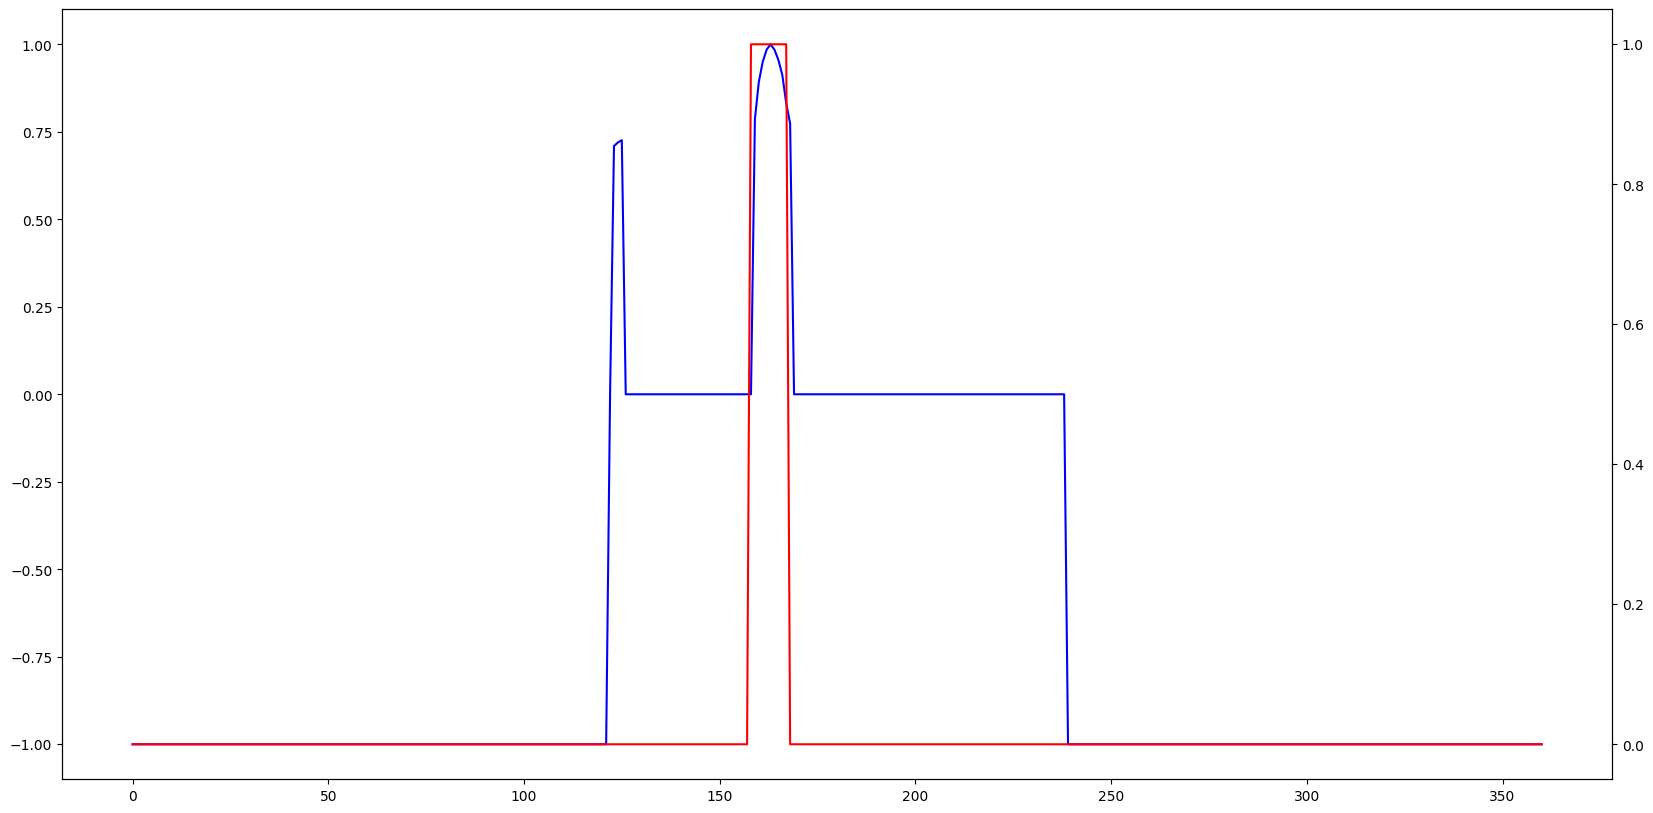

In [18]:
model.plot_sbswindow_with_mask(row_id=0)

## Peak Classification

In [19]:
# Select only precursors with more than 1 peak
peak_results_filtered = (
    peak_results.groupby("id").filter(lambda x: len(x) > 1).reset_index()
)
# Select only precursors also identified in MaxQuant single shot
peak_results_exp = peak_results_filtered.loc[peak_results_filtered.id.isin(
    selected_id)]
peak_results_exp = pd.merge(
    left=peak_results_exp,
    right=ref_exp_df_inner[[
        "id", "sbs_window_left_scan", "sbs_window_right_scan"]],
    on="id",
)

In [20]:
%autoreload 2
from postprocessing.peak_selection import prepare_peak_input
peak_arrays = prepare_peak_input(peak_results_exp, 
                                refit_activation_minima_df,
                                log_intensity=True, 
                                standardize="minmax", 
                                method= 'mask')

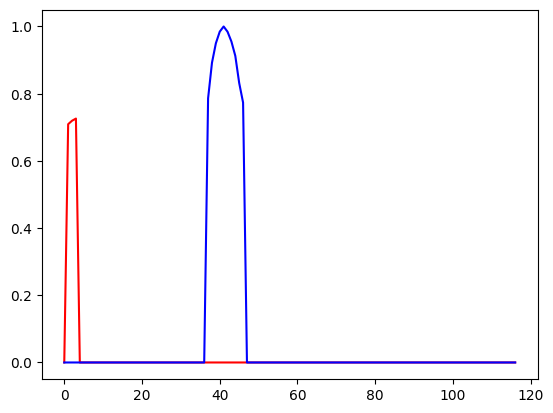

In [21]:
plt.plot(peak_arrays[0], color="red")
plt.plot(peak_arrays[1], color="blue")

In [23]:
%autoreload 2
from postprocessing.peak_selection import PeakClsModel
config = {
    "model": "CNN",
    "conv1_n_filters": 16,
    "conv1_kernel_size": 3,
    "conv2_n_filters": 32,
    "conv2_kernel_size": 5,
    "n_epochs": 100,
    "dense1_n": 128,
    "dense1_reg_rate": 0,
    "dropout_rate": 0.3,
    "learning_rate": 0.0001,
}
mdl = PeakClsModel(
    peak_input=peak_arrays,
    peak_results=peak_results_exp,
    initial_bias="auto",
    use_class_weight=True,
)
mdl.pad_peak_input(padding="two_side", value=-1.0)
mdl.split_data(by_precrusor=True, normalize=False)
#mdl.resample_train_data(resample_method="undersample")

mdl.make_model(config=config)
mdl.train_model(epochs=100, weight_class=True)

2023-12-19 13:29:20,070 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=296)
           2	LOAD_GLOBAL(arg=0, lineno=298)
           4	LOAD_METHOD(arg=1, lineno=298)
           6	LOAD_FAST(arg=1, lineno=298)
           8	BUILD_TUPLE(arg=1, lineno=298)
          10	LOAD_FAST(arg=2, lineno=298)
          12	CALL_METHOD(arg=2, lineno=298)
          14	STORE_FAST(arg=3, lineno=298)
          16	LOAD_FAST(arg=1, lineno=299)
          18	LOAD_GLOBAL(arg=2, lineno=299)
          20	LOAD_FAST(arg=0, lineno=299)
          22	CALL_FUNCTION(arg=1, lineno=299)
          24	BINARY_SUBTRACT(arg=None, lineno=299)
          26	STORE_FAST(arg=4, lineno=299)
          28	LOAD_FAST(arg=4, lineno=300)
          30	LOAD_CONST(arg=1, lineno=300)
          32	BINARY_FLOOR_DIVIDE(arg=None, lineno=300)
          34	STORE_FAST(arg=5, lineno=300)
          36	LOAD_FAST(arg=0, lineno=302)
          38	LOAD_FAST(arg=3, lineno=302)
          40	LOAD_FAST(arg=5, lineno=302)
          

Examples:
    Total: 38471
    Positive: 9989 (25.97% of total)

Epoch 1/100
1203/1203 [==============================] - 12s 9ms/step - loss: 0.5923 - cross entropy: 0.5957 - Brier score: 0.2051 - tp: 7628.0000 - fp: 10371.0000 - tn: 18111.0000 - fn: 2361.0000 - accuracy: 0.6690 - precision: 0.4238 - recall: 0.7636 - auc: 0.7577 - prc: 0.4866 - val_loss: 0.5414 - val_cross entropy: 0.5414 - val_Brier score: 0.1840 - val_tp: 2207.0000 - val_fp: 2726.0000 - val_tn: 4534.0000 - val_fn: 291.0000 - val_accuracy: 0.6908 - val_precision: 0.4474 - val_recall: 0.8835 - val_auc: 0.8344 - val_prc: 0.5785
Epoch 2/100
1203/1203 [==============================] - 10s 8ms/step - loss: 0.5091 - cross entropy: 0.5317 - Brier score: 0.1817 - tp: 8623.0000 - fp: 10045.0000 - tn: 18437.0000 - fn: 1366.0000 - accuracy: 0.7034 - precision: 0.4619 - recall: 0.8632 - auc: 0.8211 - prc: 0.5548 - val_loss: 0.4999 - val_cross entropy: 0.4999 - val_Brier score: 0.1705 - val_tp: 2158.0000 - val_fp: 2428.0000 - va

In [24]:
mdl.class_model.save(os.path.join(result_dir, "peak_cls_model.keras"))

2023-12-19 14:29:37,183 - h5py._conv - DEBUG - Creating converter from 5 to 3


In [26]:
mdl.evaluate_id_based_cls(top_n=1)
mdl.evaluate_id_based_cls(top_n=2)
mdl.evaluate_id_based_cls(top_n=3)
mdl.evaluate_id_based_cls(top_n=4)
mdl.evaluate_id_based_cls(top_n=5)
mdl.evaluate_id_based_cls(top_n=6)

305/305 [==============================] - 1s 3ms/step


0.6953562850280224

305/305 [==============================] - 1s 3ms/step


0.9315452361889511

305/305 [==============================] - 1s 3ms/step


0.9803843074459567

305/305 [==============================] - 1s 3ms/step


0.9935948759007206

305/305 [==============================] - 1s 3ms/step


0.9975980784627703

305/305 [==============================] - 1s 3ms/step


0.9987990392313851

In [69]:
import keras

best_model = keras.models.load_model(
    os.path.join(result_dir, "peak_cls_model.keras"))

2023-12-20 11:36:34,072 - h5py._conv - DEBUG - Creating converter from 3 to 5


In [71]:
accuracy, df_test = evaluate_id_based_cls(class_model=best_model, mdl=mdl, top_n=1)

305/305 [==============================] - 1s 3ms/step


<Axes: xlabel='y_pred_prob', ylabel='Density'>

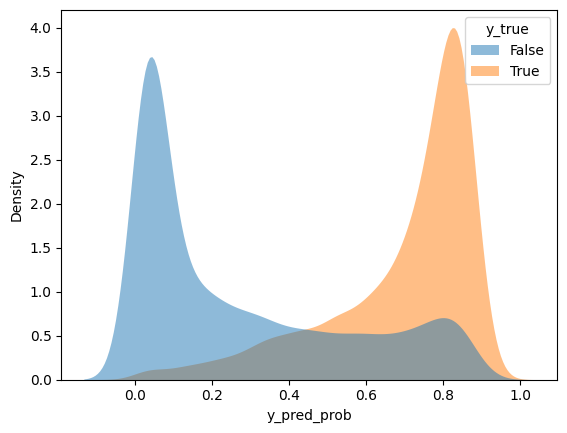

In [27]:
import seaborn as sns

test_df = mdl.df_test
sns.kdeplot(
    data=test_df,
    x="y_pred_prob",
    hue="y_true",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

   1/1203 [..............................] - ETA: 27s

1203/1203 [==============================] - 3s 3ms/step


<Axes: xlabel='y_pred_prob', ylabel='Density'>

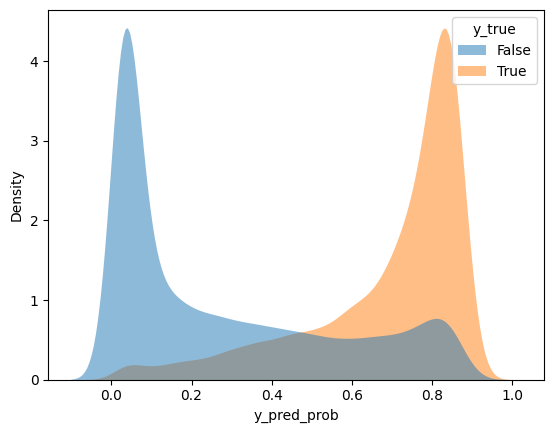

In [28]:
y_train_pred_prob = mdl.class_model.predict(mdl.X_train)
train_df = pd.DataFrame(
    {
        "precursor_id": mdl.precursor_id[mdl.train_indices],
        "y_pred_prob": y_train_pred_prob.flatten(),
        "y_true": mdl.y_train,
    }
)
sns.kdeplot(
    data=train_df,
    x="y_pred_prob",
    hue="y_true",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

In [30]:
mdl.X_train.shape

(38471, 361, 1)

# Tuning

In [39]:
import keras_tuner as kt
import tensorflow as tf
from postprocessing.peak_selection import model_tuner

tuner = kt.Hyperband(
    model_tuner,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="intro_to_kt",
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
tuner.search(
    mdl.X_train, mdl.y_train, epochs=50, validation_split=0.2, callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

Trial 30 Complete [00h 01m 37s]
val_loss: 0.39224082231521606

Best val_loss So Far: 0.3914252817630768
Total elapsed time: 00h 24m 48s


In [47]:
best_hps

In [40]:
print(
    f"""
The hyperparameter search is complete. The optimal number of filters in the first and second convolutional
layer is {best_hps.get('conv1_n_filters')} and {best_hps.get('conv2_n_filters')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
"""
)


The hyperparameter search is complete. The optimal number of filters in the first and second convolutional
layer is 112 and 80, the optimal learning rate for the optimizer
is 0.001.



## Train the best model

In [62]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc",
    verbose=1,
    patience=10,
    mode="max",
    restore_best_weights=True,
)
history = model.fit(
    mdl.X_train,
    mdl.y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
)

val_acc_per_epoch = history.history["val_prc"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

2023-12-20 10:26:38,756 - postprocessing.peak_selection - DEBUG - Output bias: <keras.initializers.initializers.Constant object at 0x7f1ce02ec3d0>


Epoch 1/50
962/962 [==============================] - 13s 12ms/step - loss: 0.4475 - cross entropy: 0.4475 - Brier score: 0.1500 - tp: 2661.0000 - fp: 2088.0000 - tn: 20680.0000 - fn: 5347.0000 - accuracy: 0.7584 - precision: 0.5603 - recall: 0.3323 - auc: 0.8066 - prc: 0.5244 - val_loss: 0.4187 - val_cross entropy: 0.4187 - val_Brier score: 0.1403 - val_tp: 64.0000 - val_fp: 23.0000 - val_tn: 5691.0000 - val_fn: 1917.0000 - val_accuracy: 0.7479 - val_precision: 0.7356 - val_recall: 0.0323 - val_auc: 0.8559 - val_prc: 0.6209
Epoch 2/50
962/962 [==============================] - 11s 11ms/step - loss: 0.4172 - cross entropy: 0.4172 - Brier score: 0.1388 - tp: 3726.0000 - fp: 2413.0000 - tn: 20355.0000 - fn: 4282.0000 - accuracy: 0.7825 - precision: 0.6069 - recall: 0.4653 - auc: 0.8389 - prc: 0.5808 - val_loss: 0.4037 - val_cross entropy: 0.4037 - val_Brier score: 0.1339 - val_tp: 866.0000 - val_fp: 404.0000 - val_tn: 5310.0000 - val_fn: 1115.0000 - val_accuracy: 0.8026 - val_precision: 

In [50]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(mdl.X_train, mdl.y_train,
               epochs=best_epoch, validation_split=0.2)

2023-12-20 10:02:12,484 - postprocessing.peak_selection - DEBUG - Output bias: <keras.initializers.initializers.Constant object at 0x7f1ce01a5d80>


Epoch 1/35
962/962 [==============================] - 13s 12ms/step - loss: 0.4433 - cross entropy: 0.4318 - Brier score: 0.1438 - tp: 4094.0000 - fp: 2765.0000 - tn: 25717.0000 - fn: 5895.0000 - accuracy: 0.7749 - precision: 0.5969 - recall: 0.4099 - auc: 0.8247 - prc: 0.5607 - val_loss: 0.4193 - val_cross entropy: 0.4193 - val_Brier score: 0.1410 - val_tp: 78.0000 - val_fp: 29.0000 - val_tn: 5685.0000 - val_fn: 1903.0000 - val_accuracy: 0.7489 - val_precision: 0.7290 - val_recall: 0.0394 - val_auc: 0.8521 - val_prc: 0.6137
Epoch 2/35
962/962 [==============================] - 11s 11ms/step - loss: 0.4187 - cross entropy: 0.4187 - Brier score: 0.1395 - tp: 3653.0000 - fp: 2421.0000 - tn: 20347.0000 - fn: 4355.0000 - accuracy: 0.7798 - precision: 0.6014 - recall: 0.4562 - auc: 0.8370 - prc: 0.5782 - val_loss: 0.4004 - val_cross entropy: 0.4004 - val_Brier score: 0.1324 - val_tp: 1371.0000 - val_fp: 948.0000 - val_tn: 4766.0000 - val_fn: 610.0000 - val_accuracy: 0.7975 - val_precision: 

In [67]:
%autoreload 2
from postprocessing.peak_selection import evaluate_id_based_cls
evaluate_id_based_cls(class_model=model, mdl=mdl, top_n=1)
evaluate_id_based_cls(class_model=model, mdl=mdl, top_n=2)
evaluate_id_based_cls(class_model=model, mdl=mdl, top_n=3)

305/305 [==============================] - 1s 3ms/step


0.6853482786228983

305/305 [==============================] - 1s 3ms/step


0.9279423538831065

305/305 [==============================] - 1s 3ms/step


0.9807846277021617

<Axes: xlabel='y_pred_prob', ylabel='Density'>

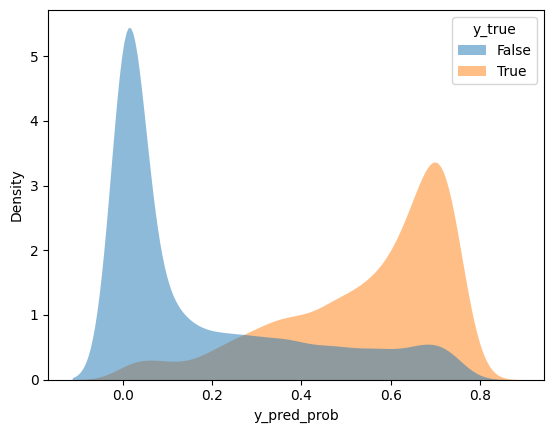

In [65]:
test_df = mdl.df_test
sns.kdeplot(
    data=test_df,
    x="y_pred_prob",
    hue="y_true",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

## Test complete flow

In [83]:
RT_ref = "predicted_RT"
RT_tol = 1.0
Maxquant_result_dict["sbs_window_left"] = Maxquant_result_dict[RT_ref] - RT_tol
Maxquant_result_dict["sbs_window_right"] = Maxquant_result_dict[RT_ref] + RT_tol
Maxquant_result_dict = match_time_to_scan(
    df=Maxquant_result_dict,
    MS1Scans_NoArray=MS1Scans_NoArray,
    time_cols=[
        "sbs_window_left",
        "sbs_window_right",
    ],
)

In [84]:
peak_results = pd.merge(
    left=peak_results,
    right=Maxquant_result_dict[[
        "id", "sbs_window_left_scan", "sbs_window_right_scan"]],
    on="id",
)

In [122]:
%autoreload 2
reload(sys.modules['postprocessing.peak_selection'])
reload(sys.modules['postprocessing.post_processing'])
from postprocessing.peak_selection import PeakClsModel
from postprocessing.post_processing import activation_peak_cls_and_sum
sum_peak, peak_results_update = activation_peak_cls_and_sum(
    activation_df=refit_activation_minima_df,
    peak_results=peak_results,
    model_path = os.path.join(result_dir, "peak_cls_model.keras"),
    return_peak_result=True,
)

<module 'postprocessing.peak_selection' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/peak_selection.py'>

<module 'postprocessing.post_processing' from '/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/postprocessing/post_processing.py'>

2023-12-20 16:33:56,071 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=296)
           2	LOAD_GLOBAL(arg=0, lineno=298)
           4	LOAD_METHOD(arg=1, lineno=298)
           6	LOAD_FAST(arg=1, lineno=298)
           8	BUILD_TUPLE(arg=1, lineno=298)
          10	LOAD_FAST(arg=2, lineno=298)
          12	CALL_METHOD(arg=2, lineno=298)
          14	STORE_FAST(arg=3, lineno=298)
          16	LOAD_FAST(arg=1, lineno=299)
          18	LOAD_GLOBAL(arg=2, lineno=299)
          20	LOAD_FAST(arg=0, lineno=299)
          22	CALL_FUNCTION(arg=1, lineno=299)
          24	BINARY_SUBTRACT(arg=None, lineno=299)
          26	STORE_FAST(arg=4, lineno=299)
          28	LOAD_FAST(arg=4, lineno=300)
          30	LOAD_CONST(arg=1, lineno=300)
          32	COMPARE_OP(arg=5, lineno=300)
          34	POP_JUMP_IF_FALSE(arg=33, lineno=300)
          36	LOAD_FAST(arg=4, lineno=301)
          38	LOAD_CONST(arg=2, lineno=301)
          40	BINARY_FLOOR_DIVIDE(arg=None, lineno=301)


peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clipped!
peak input longer than maxlen, peak input will be clippe

2023-12-20 16:33:57,650 - postprocessing.peak_selection - DEBUG - Padded sequences type: float32
2023-12-20 16:33:57,768 - postprocessing.post_processing - INFO - Loaded model from /cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_MZtol0.0_condpeakRange_alpha0.0_threshold_abthres0.001_missabthres0.5_convergence_NoIntercept_mix/peak_cls_model.keras


4537/4537 [==============================] - 13s 3ms/step


In [117]:
demo = peak_results_update.sort_values("id").iloc[0:10]
demo.groupby("id")["peak_prob"].transform(max) == demo["peak_prob"]

0    False
2    False
3    False
4    False
5    False
6     True
7    False
1    False
0     True
1     True
Name: peak_prob, dtype: bool

In [123]:
sum_peak.groupby("id").size().idxmax()

2437

In [124]:
sum_peak = pd.merge(
    left=sum_peak, right=Maxquant_result_dict[["id"]], on="id", how="right"
)

In [107]:
sum_peak_final = sum_peak.groupby("id").sum("AUCActivationPeak")

In [125]:
SBS_result = SBSResult(
    ref_df=Maxquant_result_dict,
    exp_df=Maxquant_result_exp,
    RT_tol=1.0,
    sum_peak=sum_peak_final,
)

2023-12-20 16:34:44,748 - result_analysis.result_analysis - DEBUG - Maxquant experiment file has 19186 entries.
2023-12-20 16:34:44,749 - result_analysis.result_analysis - DEBUG - columns after merge MQ dict and MQ exp Index(['Modified sequence', 'Charge', 'predicted_RT', 'id',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity', '_merge'],
      dtype='object')
2023-12-20 16:34:44,754 - result_analysis.result_analysis - DEBUG - Keeping 17758 entries with RT difference within 1.0
2023-12-20 16:34:44,754 - result_analysis.result_analysis - DEBUG - columns after filter by RT Index(['Modified sequence', 'Charge', 'predicted_RT', 'id',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity', '_merge',
       'RT_diff'],
      dtype='object')
2023-12-20 16:34:44,770 - result_analysis.result_analysis - DEBUG - Aggr

In [126]:
SBS_result.plot_intensity_corr(
    ref_col="Intensity",
    inf_col="AUCActivationPeak",
    interactive=True,
    hover_data=["id", "Modified sequence", "Charge"],
)

Data:  Intensity_log AUCActivationPeak_log , slope =  0.507 , intercept =  2.351 , PearsonR =  0.456 , SpearmanR =  0.463
